## Predicting Protein Contacts with ESM-2

Understanding how amino acids interact within a folded protein is essential for grasping protein function and stability. Contact prediction, the task of identifying which residues are close together in three-dimensional space, is a key step in the sequence to structure process. ESM-2’s learned attention patterns capture evolutionary signals that encode structural information, which allows the model to predict residue contacts directly from sequence data.

In this notebook, we'll explore ESM-2's ability to predict protein contacts across three diverse proteins from different organisms:

**Bacterial Transport:**
- **1a3a (PTS Mannitol Component)**: A phosphoenolpyruvate-dependent sugar phosphotransferase system component from *E. coli*, essential for carbohydrate metabolism

**Stress Response:**
- **5ahw (Universal Stress Protein)**: A conserved stress response protein from *Mycolicibacterium smegmatis* that helps cells survive harsh conditions

**Human Metabolism:**
- **1xcr (Ester Hydrolase)**: A human enzyme (C11orf54) involved in lipid metabolism and cellular signaling pathways

We will evaluate how effectively ESM-2 captures the structural relationships present in these sequences, measuring precision across different sequence separation ranges to assess both local and long-range contact prediction performance. This notebook is a modified version of a [notebook by the same name](https://github.com/facebookresearch/esm/blob/main/examples/contact_prediction.ipynb) from the [offical ESM repsitory](https://github.com/facebookresearch/esm).

### Setup

Here we import all neccessary libraries.

In [1]:
from typing import List, Tuple, Optional, Dict
import string

import mlx.core as mx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist
import biotite.structure as bs
from biotite.database import rcsb
from biotite.structure.io.pdbx import CIFFile, get_structure
from Bio import SeqIO

Download multiple sequence alignment (MSA) files for our three test proteins from the ESM repository.

In [2]:
!mkdir -p data
!curl -o data/1a3a_1_A.a3m https://raw.githubusercontent.com/facebookresearch/esm/main/examples/data/1a3a_1_A.a3m
!curl -o data/5ahw_1_A.a3m https://raw.githubusercontent.com/facebookresearch/esm/main/examples/data/5ahw_1_A.a3m
!curl -o data/1xcr_1_A.a3m https://raw.githubusercontent.com/facebookresearch/esm/main/examples/data/1xcr_1_A.a3m

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  147k  100  147k    0     0   536k      0 --:--:-- --:--:-- --:--:--  538k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  127k  100  127k    0     0   485k      0 --:--:-- --:--:-- --:--:--  486k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  181k  100  181k    0     0   738k      0 --:--:-- --:--:-- --:--:--  740k


### Loading the model

Load the ESM-2 model. Change the path below to point to your converted checkpoint.

In [3]:
import sys
sys.path.append("..")

from esm import ESM2

esm_checkpoint = "../checkpoints/mlx-esm2_t33_650M_UR50D"
tokenizer, model = ESM2.from_pretrained(esm_checkpoint)

### Defining functions

#### Parsing alignments

This function parses multiple sequence alignment files and clean up insertion artifacts. MSA files often contain lowercase letters and special characters (`.`, `*`) to indicate insertions relative to the reference sequence - these need to be removed to get the core aligned sequences.

In [4]:
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)

def read_msa(filename: str) -> List[Tuple[str, str]]:
    """ Reads the sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(filename, "fasta")]

#### Converting structures to contacts

There are many ways to define a protein contact. Here we're using the definition of 8 angstroms between carbon beta atoms. Note that the position of the carbon beta is imputed from the position of the N, CA, and C atoms for each residue.

In [5]:
def extend(a, b, c, L, A, D):
    """
    input:  3 coords (a,b,c), (L)ength, (A)ngle, and (D)ihedral
    output: 4th coord
    """
    def normalize(x):
        return x / np.linalg.norm(x, ord=2, axis=-1, keepdims=True)

    bc = normalize(b - c)
    n = normalize(np.cross(b - a, bc))
    m = [bc, np.cross(n, bc), n]
    d = [L * np.cos(A), L * np.sin(A) * np.cos(D), -L * np.sin(A) * np.sin(D)]
    return c + sum([m * d for m, d in zip(m, d)])

def contacts_from_pdb(
    structure: bs.AtomArray,
    distance_threshold: float = 8.0,
    chain: Optional[str] = None,
) -> np.ndarray:
    """Extract contacts from PDB structure."""
    mask = ~structure.hetero
    if chain is not None:
        mask &= structure.chain_id == chain

    N = structure.coord[mask & (structure.atom_name == "N")]
    CA = structure.coord[mask & (structure.atom_name == "CA")]
    C = structure.coord[mask & (structure.atom_name == "C")]

    Cbeta = extend(C, N, CA, 1.522, 1.927, -2.143)
    dist = squareform(pdist(Cbeta))
    
    contacts = dist < distance_threshold
    contacts = contacts.astype(np.int64)
    contacts[np.isnan(dist)] = -1
    return contacts

#### Computing contact precisions

Calculate precision metrics to evaluate contact prediction quality. The `compute_precisions` function ranks predicted contacts by confidence and measures how many of the top predictions are true contacts, while `evaluate_prediction` breaks this down by sequence separation ranges (local, short, medium, long-range) since predicting distant contacts is typically much harder than nearby ones.

In [6]:
def compute_precisions(
    predictions: mx.array,
    targets: mx.array,
    minsep: int = 6,
    maxsep: Optional[int] = None,
    override_length: Optional[int] = None,
) -> Dict[str, mx.array]:
    """Compute precision metrics for contact prediction."""
    batch_size, seqlen, _ = predictions.shape
    
    if maxsep is not None:
        sep_mask_2d = mx.abs(mx.arange(seqlen)[None, :] - mx.arange(seqlen)[:, None]) <= maxsep
        targets = targets * sep_mask_2d[None, :]
    
    targets = targets.astype(mx.float32)
    src_lengths = (targets >= 0).sum(axis=-1).sum(axis=-1).astype(mx.float32)
    
    x_ind, y_ind = [], []
    for i in range(seqlen):
        for j in range(i + minsep, seqlen):
            x_ind.append(i)
            y_ind.append(j)
    
    x_ind = mx.array(x_ind)
    y_ind = mx.array(y_ind)
    
    predictions_upper = predictions[:, x_ind, y_ind]
    targets_upper = targets[:, x_ind, y_ind]

    topk = seqlen if override_length is None else max(seqlen, override_length)
    indices = mx.argsort(predictions_upper, axis=-1)[:, ::-1][:, :topk]
    
    batch_indices = mx.arange(batch_size)[:, None]
    topk_targets = targets_upper[batch_indices, indices]
    
    if topk_targets.shape[1] < topk:
        pad_shape = (topk_targets.shape[0], topk - topk_targets.shape[1])
        padding = mx.zeros(pad_shape)
        topk_targets = mx.concatenate([topk_targets, padding], 1)

    cumulative_dist = mx.cumsum(topk_targets, -1)

    gather_lengths = src_lengths[:, None]
    if override_length is not None:
        gather_lengths = override_length * mx.ones_like(gather_lengths)

    precision_fractions = mx.arange(0.1, 1.1, 0.1)
    gather_indices = (precision_fractions[None, :] * gather_lengths) - 1
    gather_indices = mx.clip(gather_indices, 0, cumulative_dist.shape[1] - 1)
    gather_indices = gather_indices.astype(mx.int32)

    binned_cumulative_dist = cumulative_dist[batch_indices, gather_indices]
    binned_precisions = binned_cumulative_dist / (gather_indices + 1)

    pl5 = binned_precisions[:, 1]
    pl2 = binned_precisions[:, 4]
    pl = binned_precisions[:, 9]
    auc = binned_precisions.mean(-1)

    return {"AUC": auc, "P@L": pl, "P@L2": pl2, "P@L5": pl5}

def evaluate_prediction(
    predictions: mx.array,
    targets: mx.array,
) -> Dict[str, float]:
    """Evaluate contact predictions across different sequence separation ranges."""
    contact_ranges = [
        ("local", 3, 6),
        ("short", 6, 12),
        ("medium", 12, 24),
        ("long", 24, None),
    ]
    metrics = {}
    
    for name, minsep, maxsep in contact_ranges:
        rangemetrics = compute_precisions(
            predictions,
            targets,
            minsep=minsep,
            maxsep=maxsep,
        )
        for key, val in rangemetrics.items():
            metrics[f"{name}_{key}"] = float(val[0])
    return metrics

#### Predicting contacts

This function wraps the tokenization and model inference steps, converting a raw amino acid sequence into token IDs and passing them through ESM-2's contact prediction head to produce a contact probability matrix.

In [7]:
def predict_contacts(sequence: str, model, tokenizer) -> mx.array:
    tokens = tokenizer.encode(sequence)
    tokens = mx.array([tokens])
    contacts = model.predict_contacts(tokens)
    return contacts

#### Plotting results

This function visualizes contacts as a symmetric matrix where both axes index residue positions. The lower triangle shows the model’s confidence as a blue heatmap, with darker cells indicating higher confidence. The upper triangle overlays evaluation markers: blue dots are correctly predicted contacts (true positives), red dots are predicted but not real (false positives), and grey dots are real contacts the model missed (false negatives).

In [8]:
def plot_contacts_and_predictions(
    predictions: mx.array,
    contacts: np.ndarray,
    ax,
    title: str,
    cmap: str = "Blues",
    ms: float = 1,
):
    """Plot contact predictions and true contacts."""
    if isinstance(predictions, mx.array):
        predictions = np.array(predictions)
    
    seqlen = contacts.shape[0]
    relative_distance = np.add.outer(-np.arange(seqlen), np.arange(seqlen))
    bottom_mask = relative_distance < 0
    masked_image = np.ma.masked_where(bottom_mask, predictions)
    invalid_mask = np.abs(np.add.outer(np.arange(seqlen), -np.arange(seqlen))) < 6
    predictions_copy = predictions.copy()
    predictions_copy[invalid_mask] = float("-inf")

    topl_val = np.sort(predictions_copy.reshape(-1))[-seqlen]
    pred_contacts = predictions_copy >= topl_val
    true_positives = contacts & pred_contacts & ~bottom_mask
    false_positives = ~contacts & pred_contacts & ~bottom_mask
    other_contacts = contacts & ~pred_contacts & ~bottom_mask

    ax.imshow(masked_image, cmap=cmap)
    ax.plot(*np.where(other_contacts), "o", c="grey", ms=ms)
    ax.plot(*np.where(false_positives), "o", c="r", ms=ms)
    ax.plot(*np.where(true_positives), "o", c="b", ms=ms)
    ax.set_title(title)
    ax.axis("square")
    ax.set_xlim([0, seqlen])
    ax.set_ylim([0, seqlen])

### Predict and visualize
Here we'll use ESM-2 contact prediction on our three test proteins and evaluate the results. We'll compute precision metrics across different sequence separation ranges and create contact maps that visualize both the model's predictions and how well they match the true protein structures.

#### Read Data

Load experimental protein structures from the Protein Data Bank and extract true contact maps for evaluation, while also parsing the reference sequences from our MSA files that will serve as input to ESM-2.

In [9]:
PDB_IDS = ["1a3a", "5ahw", "1xcr"]

structures = {
    name.lower(): get_structure(CIFFile.read(rcsb.fetch(name, "cif")))[0]
    for name in PDB_IDS
}

contacts = {
    name: contacts_from_pdb(structure, chain="A") 
    for name, structure in structures.items()
}

msas = {
    name: read_msa(f"data/{name.lower()}_1_A.a3m")
    for name in PDB_IDS
}

sequences = {
    name: msa[0] for name, msa in msas.items()
}

#### ESM-2 predictions

##### Evaluate predictions

This loop generates contact predictions for each protein using ESM-2, compares them against the experimentally determined structures, and computes precision metrics across different sequence separation ranges to evaluate model performance.

In [10]:
predictions = {}
results = []

for pdb_id in sequences:
    _, sequence = sequences[pdb_id]
    prediction = predict_contacts(sequence, model, tokenizer)
    predictions[pdb_id] = prediction[0]
 
    true_contacts = mx.array(contacts[pdb_id])
    
    min_len = min(prediction.shape[1], true_contacts.shape[0])
    pred_trimmed = prediction[:, :min_len, :min_len]
    true_trimmed = true_contacts[:min_len, :min_len]
    true_trimmed = mx.expand_dims(true_trimmed, axis=0)
    
    metrics = evaluate_prediction(pred_trimmed, true_trimmed)
    result = {"id": pdb_id, "model": "ESM-2 (Unsupervised)"}
    result.update(metrics)
    results.append(result)

results_df = pd.DataFrame(results)
display(results_df)

,id,model,local_AUC,local_P@L,local_P@L2,local_P@L5,short_AUC,short_P@L,short_P@L2,short_P@L5,medium_AUC,medium_P@L,medium_P@L2,medium_P@L5,long_AUC,long_P@L,long_P@L2,long_P@L5
0,1a3a,ESM-2 (Unsupervised),0.193103,0.193103,0.193103,0.193103,0.172414,0.172414,0.172414,0.172414,0.262069,0.262069,0.262069,0.262069,0.689655,0.689655,0.689655,0.689655
1,5ahw,ESM-2 (Unsupervised),0.024000,0.024000,0.024000,0.024000,0.136000,0.136000,0.136000,0.136000,0.144000,0.144000,0.144000,0.144000,0.864000,0.864000,0.864000,0.864000
2,1xcr,ESM-2 (Unsupervised),0.111821,0.111821,0.111821,0.111821,0.159744,0.159744,0.159744,0.159744,0.175719,0.175719,0.175719,0.175719,0.408946,0.408946,0.408946,0.408946


The results demonstrate that ESM-2 excels at predicting long-range contacts, with precision scores ranging from 40.9% to 86.4% for residues more than 24 positions apart. Performance is consistently higher for distant contacts compared to local ones. For example, the universal stress protein (5ahw) achieves 86.4% precision for long-range contacts but only 2.4% for local contacts between 3 and 6 residues apart. This trend is observed across all three proteins, with medium-range contacts (12–24 residues apart) and short-range contacts (6–12 residues apart) showing intermediate accuracy. These results suggest that ESM-2 has learned to identify evolutionarily conserved structural motifs that connect distant regions of the sequence, which are often critical for protein fold stability and function.

##### Plot contacts and predictions

This analysis generates contact map visualizations for all three proteins, presenting ESM-2’s predictions as heatmaps and overlaying the true experimental contacts as colored dots.

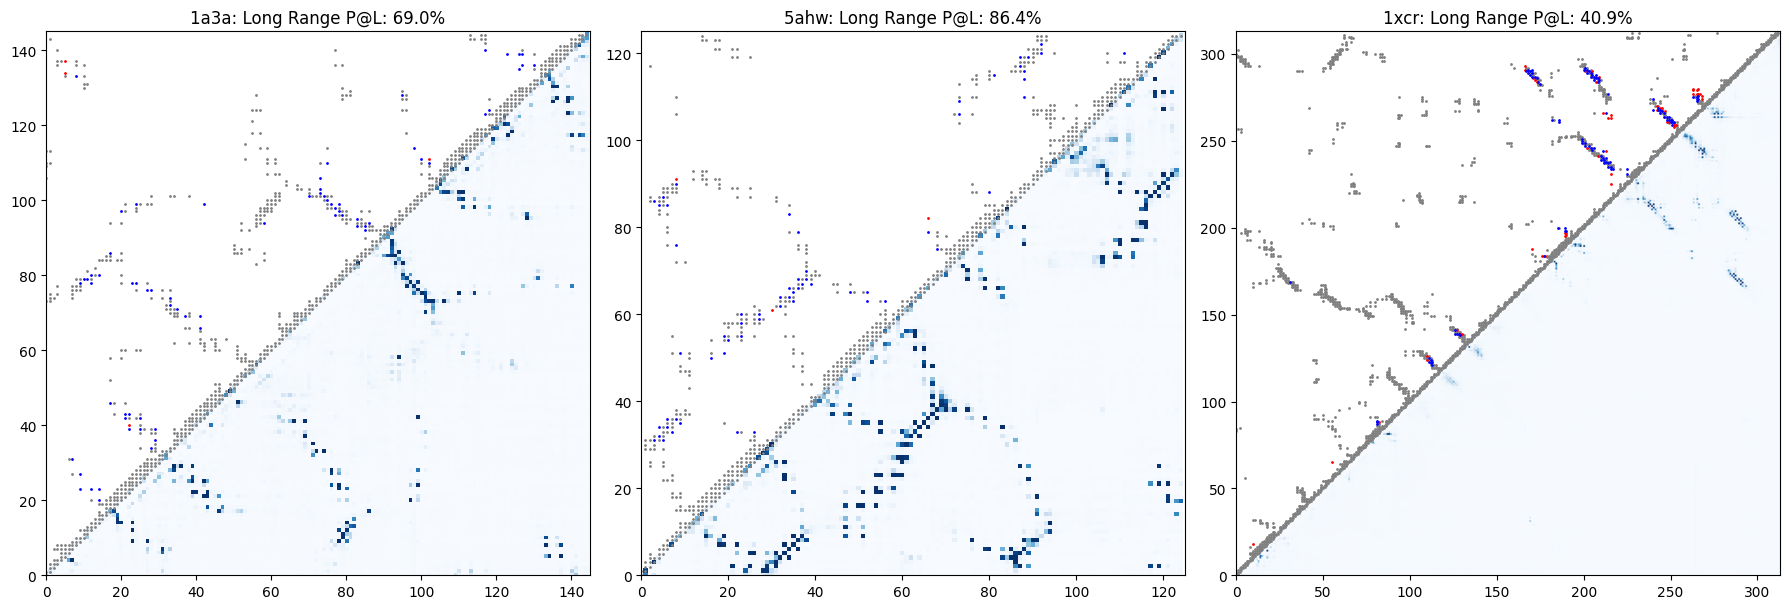

In [11]:
proteins = [r['id'] for r in results]
fig, axes = plt.subplots(figsize=(6 * len(proteins), 6), ncols=len(proteins))
if len(proteins) == 1:
    axes = [axes]

for ax, pdb_id in zip(axes, proteins):
    prediction = predictions[pdb_id]
    target = contacts[pdb_id]
    
    result = next(r for r in results if r['id'] == pdb_id)
    long_pl = result['long_P@L']
    
    plot_contacts_and_predictions(
        prediction, target, ax=ax, 
        title=f"{pdb_id}: Long Range P@L: {100 * long_pl:.1f}%"
    )

plt.tight_layout()
plt.show()

The contact maps highlight ESM-2’s strong ability to detect long-range structural relationships. In each panel, the lower triangle shows model predictions, where darker blue regions indicate high-confidence contacts, and the upper triangle shows the corresponding experimental data. Correct predictions appear as blue dots, forming distinct off-diagonal patterns in 5ahw and 1a3a that capture key global fold interactions. Red dots mark false positives, which are relatively rare, while grey dots represent missed contacts. These missed contacts are notably more frequent in 1xcr, consistent with its lower long-range precision. The dense clusters of blue true positives in 5ahw, compared to the sparser, fragmented patterns in 1xcr, clearly illustrate the variation in predictive performance across proteins.